Processing audio...
Loading model...
1/1 [==============================] - 2s 2s/step
Plotting predictions...
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


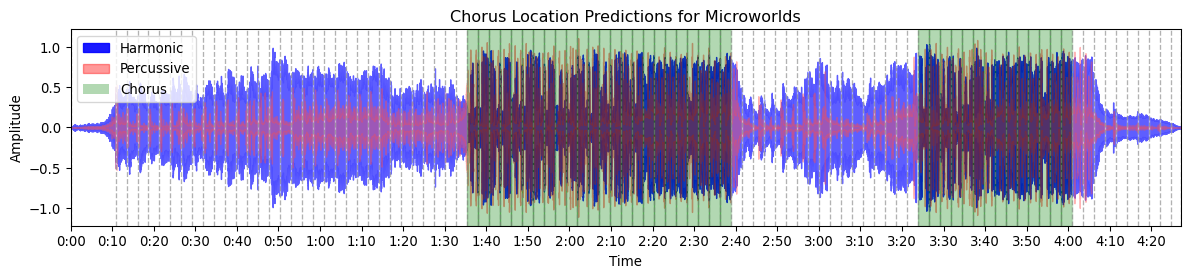

In [3]:
"""
Module for chorus detection in audio files.

This module provides functions for downloading audio files from YouTube URLs,
processing audio data, loading a pre-trained CRNN model, making predictions
on the processed audio data, and visualizing the predictions.
"""

# Standard library imports
import argparse
import os
import warnings
from functools import reduce
from typing import List, Tuple

# Related third-party imports
import librosa
import numpy as np
from matplotlib import pyplot as plt
from pydub import AudioSegment
from pydub.silence import detect_nonsilent
from pytube import YouTube
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Ignore specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Constants
SR = 12000
HOP_LENGTH = 128
MAX_FRAMES = 296
MAX_METERS = 204
N_FEATURES = 36
MODEL_PATH = "../models/CRNN/best_model.h5"


def download_audio(url, output_path='audio_files'):
    """
    Downloads audio from YouTube URL and saves as MP3 in the specified output path.

    Parameters:
    - url (str): YouTube URL of the audio file.
    - output_path (str): Path to save the downloaded audio file.

    Returns:
    - str: Path to the downloaded audio file, or None if the download fails.
    """
    yt = YouTube(url)
    audio = yt.streams.filter(only_audio=True).first()

    # Create the output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Download the audio file to the specified output path
    out_file = audio.download(output_path)
    base, ext = os.path.splitext(out_file)
    audio_file = base + '.mp3'

    # Check if the file exists and delete it
    if os.path.exists(audio_file):
        os.remove(audio_file)

    os.rename(out_file, audio_file)
    return audio_file


def strip_silence(audio_path):
    """Removes silent parts from an audio file."""
    sound = AudioSegment.from_file(audio_path)
    nonsilent_ranges = detect_nonsilent(
        sound, min_silence_len=500, silence_thresh=-50)
    stripped = reduce(lambda acc, val: acc + sound[val[0]:val[1]],
                      nonsilent_ranges, AudioSegment.empty())
    stripped.export(audio_path, format='mp3')


class AudioFeature:
    """
    Class for extracting and processing audio features.
    """

    def __init__(self, audio_path, sr=SR, hop_length=HOP_LENGTH):
        self.audio_path = audio_path
        self.beats = None
        self.chroma_acts = None
        self.chromagram = None
        self.combined_features = None
        self.hop_length = hop_length
        self.key, self.mode = None, None
        self.mel_acts = None
        self.melspectrogram = None
        self.meter_grid = None
        self.mfccs = None
        self.onset_env = None
        self.rms = None
        self.spectrogram = None
        self.sr = sr
        self.tempo = None
        self.tempogram = None
        self.tempogram_acts = None
        self.time_signature = 4
        self.y = None
        self.y_harm, self.y_perc = None, None

    def detect_key(self, chroma_vals: np.ndarray) -> Tuple[str, str]:
        """Detect the key and mode (major or minor) of the audio segment."""
        note_names = ['C', 'C#', 'D', 'D#', 'E',
                      'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
        major_profile = np.array(
            [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
        minor_profile = np.array(
            [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
        major_profile /= np.linalg.norm(major_profile)
        minor_profile /= np.linalg.norm(minor_profile)

        major_correlations = [np.corrcoef(chroma_vals, np.roll(major_profile, i))[
            0, 1] for i in range(12)]
        minor_correlations = [np.corrcoef(chroma_vals, np.roll(minor_profile, i))[
            0, 1] for i in range(12)]

        max_major_idx = np.argmax(major_correlations)
        max_minor_idx = np.argmax(minor_correlations)

        self.mode = 'major' if major_correlations[max_major_idx] > minor_correlations[max_minor_idx] else 'minor'
        self.key = note_names[max_major_idx if self.mode ==
                              'major' else max_minor_idx]
        return self.key, self.mode

    def calculate_ki_chroma(self, waveform: np.ndarray, sr: int, hop_length: int) -> np.ndarray:
        """Calculate a normalized, key-invariant chromagram for the given audio waveform."""
        chromagram = librosa.feature.chroma_cqt(
            y=waveform, sr=sr, hop_length=hop_length, bins_per_octave=24)
        chromagram = (chromagram - chromagram.min()) / \
            (chromagram.max() - chromagram.min())
        chroma_vals = np.sum(chromagram, axis=1)
        key, mode = self.detect_key(chroma_vals)
        key_idx = ['C', 'C#', 'D', 'D#', 'E', 'F',
                   'F#', 'G', 'G#', 'A', 'A#', 'B'].index(key)
        shift_amount = -key_idx if mode == 'major' else -(key_idx + 3) % 12
        return librosa.util.normalize(np.roll(chromagram, shift_amount, axis=0), axis=1)

    def extract_features(self):
        """Extract various audio features from the loaded audio."""
        self.y, self.sr = librosa.load(self.audio_path, sr=self.sr)
        self.y_harm, self.y_perc = librosa.effects.hpss(self.y)
        self.spectrogram, _ = librosa.magphase(
            librosa.stft(self.y, hop_length=self.hop_length))
        self.rms = librosa.feature.rms(
            S=self.spectrogram, hop_length=self.hop_length)
        self.melspectrogram = librosa.feature.melspectrogram(
            y=self.y, sr=self.sr, n_mels=128, hop_length=self.hop_length)
        self.mel_acts = librosa.decompose.decompose(
            self.melspectrogram, n_components=4, sort=True)[1]
        self.chromagram = self.calculate_ki_chroma(
            self.y_harm, self.sr, self.hop_length)
        self.chroma_acts = librosa.decompose.decompose(
            self.chromagram, n_components=3, sort=True)[1]
        self.onset_env = librosa.onset.onset_strength(
            y=self.y_perc, sr=self.sr, hop_length=self.hop_length)
        self.tempogram = np.clip(librosa.feature.tempogram(
            onset_envelope=self.onset_env, sr=self.sr, hop_length=self.hop_length), 0, None)
        self.tempogram_acts = librosa.decompose.decompose(
            self.tempogram, n_components=3, sort=True)[1]
        self.mfccs = librosa.feature.mfcc(
            y=self.y, sr=self.sr, n_mfcc=13, hop_length=self.hop_length)

        features = [self.rms, self.mel_acts, self.chromagram, self.chroma_acts,
                    self.tempogram_acts, self.mfccs]
        feature_names = ['rms', 'mel_acts', 'chromagram',
                         'chroma_acts', 'tempogram_acts', 'mfccs']
        dims = {name: feature.shape[0]
                for feature, name in zip(features, feature_names)}
        total_inv_dim = sum(1 / dim for dim in dims.values())
        weights = {name: 1 / (dims[name] * total_inv_dim)
                   for name in feature_names}
        std_weighted_features = [StandardScaler().fit_transform(feature.T).T * weights[name]
                                 for feature, name in zip(features, feature_names)]
        self.combined_features = np.concatenate(
            std_weighted_features, axis=0).T

    def create_meter_grid(self):
        """Create a grid based on the meter of the song, using tempo and beats."""
        self.tempo, self.beats = librosa.beat.beat_track(
            onset_envelope=self.onset_env, sr=self.sr, hop_length=self.hop_length)
        self.tempo = self.tempo * 2 if self.tempo < 70 else self.tempo / \
            2 if self.tempo > 140 else self.tempo
        self.meter_grid = self._create_meter_grid(frame_duration=len(self.onset_env))
        return self.meter_grid

    def _create_meter_grid(self, frame_duration: int) -> np.ndarray:
        """
        Helper function to create a meter grid for the song.

        Parameters:
        - frame_duration (int): The duration of the song in frame units.

        Returns:
        - np.ndarray: The meter grid.
        """
        beat_interval = int(librosa.time_to_frames(
            60 / self.tempo, sr=self.sr, hop_length=self.hop_length))
        best_match_start = max((1 - abs(np.mean(self.beats[i:i+3]) - beat_interval) / beat_interval, self.beats[i])
                            for i in range(len(self.beats) - 2))[1]
        anchor_frame = best_match_start if best_match_start > 0.95 else self.beats[0]
        beat_grid = np.arange(anchor_frame, -beat_interval, -beat_interval)
        beat_grid = beat_grid[beat_grid >= 0]
        meter_grid = np.arange(
            beat_grid[0], frame_duration + 1, beat_interval * self.time_signature)
        return np.unique(np.concatenate((meter_grid, [0, frame_duration])))


def segment_data_meters(data: np.ndarray, meter_grid: List[int]) -> List[np.ndarray]:
    """
    Divide song data into segments based on measure grid frames.

    Parameters:
    - data (np.ndarray): The song data to be segmented.
    - meter_grid (List[int]): The grid indicating the start of each measure.

    Returns:
    - List[np.ndarray]: A list of song data segments.
    """
    return [data[s:e] for s, e in zip(meter_grid[:-1], meter_grid[1:])]


def positional_encoding(position: int, d_model: int) -> np.ndarray:
    """
    Generate a positional encoding for a given position and model dimension.

    Parameters:
    - position (int): The position for which to generate the encoding.
    - d_model (int): The dimension of the model.

    Returns:
    - np.ndarray: The positional encoding.
    """
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(
        10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    return np.concatenate([np.sin(angle_rads[:, 0::2]), np.cos(angle_rads[:, 1::2])], axis=-1)


def apply_hierarchical_positional_encoding(segments: List[np.ndarray]) -> List[np.ndarray]:
    """
    Apply positional encoding at the meter and frame levels to a list of segments.

    Parameters:
    - segments (List[np.ndarray]): The list of segments to encode.

    Returns:
    - List[np.ndarray]: The list of segments with applied positional encoding.
    """
    n_features = segments[0].shape[1]
    measure_level_encodings = positional_encoding(len(segments), n_features)
    return [
        seg + positional_encoding(len(seg), n_features) +
        measure_level_encodings[i]
        for i, seg in enumerate(segments)
    ]


def pad_song(encoded_segments: List[np.ndarray], max_frames: int = MAX_FRAMES, max_meters: int = MAX_METERS, n_features: int = N_FEATURES) -> np.ndarray:
    """
    Pad or truncate the encoded segments to have the specified max_frames and max_meters dimensions.

    Parameters:
    - encoded_segments (List[np.ndarray]): The encoded segments to pad or truncate.
    - max_frames (int): The maximum number of frames per segment.
    - max_meters (int): The maximum number of meters.
    - n_features (int): The number of features per frame.

    Returns:
    - np.ndarray: The padded or truncated song.
    """
    padded_meters = [
        np.pad(meter[:max_frames], ((0, max(0, max_frames -
               meter.shape[0])), (0, 0)), 'constant', constant_values=0)
        for meter in encoded_segments
    ]
    padding_meter = np.zeros((max_frames, n_features))
    padded_song = np.array(
        padded_meters[:max_meters] + [padding_meter] * max(0, max_meters - len(padded_meters)))
    return padded_song


def process_audio(audio_path, trim_silence=True, sr=SR, hop_length=HOP_LENGTH):
    """
    Process an audio file, extracting features and applying positional encoding.

    Parameters:
    - audio_path (str): The path to the audio file.
    - trim_silence (bool): Whether to trim silence from the audio.
    - sr (int): The sample rate to use when loading the audio.
    - hop_length (int): The hop length to use for feature extraction.

    Returns:
    - Tuple[np.ndarray, AudioFeature]: The processed audio and its features.
    """
    if trim_silence:
        strip_silence(audio_path)

    audio_features = AudioFeature(
        audio_path=audio_path, sr=sr, hop_length=hop_length)
    audio_features.extract_features()
    audio_features.create_meter_grid()
    audio_segments = segment_data_meters(
        audio_features.combined_features, audio_features.meter_grid)
    encoded_audio_segments = apply_hierarchical_positional_encoding(
        audio_segments)
    processed_audio = np.expand_dims(pad_song(encoded_audio_segments), axis=0)

    return processed_audio, audio_features


def load_CRNN_model(model_path: str) -> tf.keras.Model:
    """
    Load a CRNN model with custom loss and accuracy functions.

    This function is designed for loading models that were trained with
    custom loss and accuracy functions. Placeholder functions are used
    for loading the model when only predictions are needed.

    Parameters:
    - model_path (str): Path to the saved model.

    Returns:
    - tf.keras.Model: Loaded Keras model.
    """
    # Placeholder functions for loading the model
    def custom_binary_crossentropy(y_true, y_pred):
        return y_pred

    def custom_accuracy(y_true, y_pred):
        return y_pred

    custom_objects = {
        'custom_binary_crossentropy': custom_binary_crossentropy,
        'custom_accuracy': custom_accuracy
    }

    model = tf.keras.models.load_model(
        model_path, custom_objects=custom_objects)
    return model


def smooth_predictions(data: np.ndarray) -> np.ndarray:
    """
    Smooth predictions by correcting isolated mispredictions and removing short sequences of 1s.

    This function applies a smoothing algorithm to correct isolated zeros and ones in a sequence
    of binary predictions. It also removes isolated sequences of 1s that are shorter than 5.

    Parameters:
    - data (np.ndarray): Array of binary predictions.

    Returns:
    - np.ndarray: Smoothed array of binary predictions.
    """
    if not isinstance(data, np.ndarray):
        data = np.array(data)

    # First pass: Correct isolated 0's
    data_first_pass = data.copy()
    for i in range(1, len(data) - 1):
        if data[i] == 0 and data[i - 1] == 1 and data[i + 1] == 1:
            data_first_pass[i] = 1

    # Second pass: Correct isolated 1's
    corrected_data = data_first_pass.copy()
    for i in range(1, len(data_first_pass) - 1):
        if data_first_pass[i] == 1 and data_first_pass[i - 1] == 0 and data_first_pass[i + 1] == 0:
            corrected_data[i] = 0

    # Third pass: Remove short sequences of 1s (less than 5)
    smoothed_data = corrected_data.copy()
    sequence_start = None
    for i in range(len(corrected_data)):
        if corrected_data[i] == 1:
            if sequence_start is None:
                sequence_start = i
        else:
            if sequence_start is not None:
                sequence_length = i - sequence_start
                if sequence_length < 5:
                    smoothed_data[sequence_start:i] = 0
                sequence_start = None

    return smoothed_data


def plot_meter_lines(ax: plt.Axes, meter_grid_times: np.ndarray) -> None:
    """
    Draw meter grid lines on the plot.

    Parameters:
    - ax (plt.Axes): The matplotlib axes object to draw on.
    - meter_grid_times (np.ndarray): Array of times at which to draw the meter lines.
    """
    for time in meter_grid_times:
        ax.axvline(x=time, color='grey', linestyle='--',
                   linewidth=1, alpha=0.6)


def plot_predictions(audio_features, binary_predictions: np.ndarray, output_plot_path: str = None) -> None:
    """
    Plot the audio waveform and overlay the predicted chorus locations.

    Parameters:
    - audio_features: An object containing audio features including meter grid, harmonic and percussive components.
    - binary_predictions (np.ndarray): Array of binary predictions indicating chorus (1) and non-chorus (0) segments.
    - output_plot_path (str, optional): Path to save the plot. If None, the plot is saved to 'src/plots' by default.
    """
    meter_grid_times = librosa.frames_to_time(
        audio_features.meter_grid, sr=audio_features.sr, hop_length=audio_features.hop_length)
    fig, ax = plt.subplots(figsize=(12.5, 3), dpi=96)

    librosa.display.waveshow(audio_features.y_harm, sr=audio_features.sr,
                             alpha=0.9, ax=ax, label='Harmonic', color='b')
    librosa.display.waveshow(audio_features.y_perc, sr=audio_features.sr,
                             alpha=0.4, ax=ax, label='Percussive', color='r')
    plot_meter_lines(ax, meter_grid_times)

    for i, prediction in enumerate(binary_predictions):
        start_time = meter_grid_times[i]
        end_time = meter_grid_times[i + 1] if i < len(
            meter_grid_times) - 1 else len(audio_features.y) / audio_features.sr
        if prediction == 1:
            ax.axvspan(start_time, end_time, color='green', alpha=0.3,
                       label='Predicted Chorus' if i == 0 else None)
        else:
            ax.axvspan(start_time, end_time, color='white', alpha=0.3)

    ax.set_xlim([0, len(audio_features.y) / audio_features.sr])
    ax.set_ylabel('Amplitude')
    audio_file_name = os.path.basename(audio_features.audio_path)
    ax.set_title(
        f'Chorus Location Predictions for {os.path.splitext(audio_file_name)[0]}')

    # Add a green square patch to represent "Chorus" in the legend
    chorus_patch = plt.Rectangle((0, 0), 1, 1, fc='green', alpha=0.3)
    handles, labels = ax.get_legend_handles_labels()
    handles.append(chorus_patch)
    labels.append('Chorus')
    ax.legend(handles=handles, labels=labels)

    # Set x-tick labels every 10 seconds in single-digit minutes format
    duration = len(audio_features.y) / audio_features.sr
    xticks = np.arange(0, duration, 10)
    xlabels = [f"{int(tick // 60)}:{int(tick % 60):02d}" for tick in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    plt.tight_layout()

    if output_plot_path:
        plt.savefig(output_plot_path)
    else:
        plot_save_path = "plots"
        os.makedirs(plot_save_path, exist_ok=True)
        output_plot_path = os.path.join(
            plot_save_path, os.path.splitext(audio_file_name)[0] + "_plot.png")
        plt.savefig(output_plot_path)

    plt.show()


def main(url: str, model_path: str, verbose: bool, output_plot: str = None):
    """
    Downloads audio, processes it, predicts chorus locations, and visualizes results.

    Parameters:
    - url (str): YouTube URL of the audio file.
    - model_path (str): Path to the pretrained model.
    - verbose (bool): If True, print detailed logs during the process.
    - output_plot (str, optional): Path to save the plot. If None, the plot is saved to 'src/plots' by default.
    """
    audio_save_path = "audio_files"  # Relative path from the src directory
    plot_save_path = "plots"  # Relative path from the src directory

    # Ensure the directories exist
    os.makedirs(audio_save_path, exist_ok=True)
    os.makedirs(plot_save_path, exist_ok=True)

    if verbose:
        print("Downloading audio...")
    # Modify download_audio to accept a destination path
    audio_path = download_audio(url)
    if not audio_path:
        print("Failed to download audio from the provided URL.")
        return

    if verbose:
        print("Processing audio...")
    processed_audio, audio_features = process_audio(audio_path)

    if verbose:
        print("Loading model...")
    model = load_CRNN_model(model_path=model_path)
    predictions = model.predict(processed_audio)[0]
    binary_predictions = np.round(
        predictions[:(len(audio_features.meter_grid) - 1)]).flatten()
    smoothed_predictions = smooth_predictions(binary_predictions)

    if verbose:
        print("Plotting predictions...")
        print(smoothed_predictions)
    # Modify plot_predictions to accept a save path
    output_plot_path = output_plot if output_plot else os.path.join(
        plot_save_path, os.path.basename(url) + "_plot.png")
    plot_predictions(audio_features, smoothed_predictions, output_plot_path)

main(url="https://www.youtube.com/watch?v=bO9N5PrmFco", model_path="../models/CRNN/best_model.h5", verbose=True, output_plot="plots")



In [ ]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description="Chorus detection in audio files.")
    parser.add_argument("url", help="YouTube URL of the audio file.")
    parser.add_argument("--model_path", help="Path to the pretrained model.",
                        default="../models/CRNN/best_model.h5")
    parser.add_argument("--verbose", action="store_true",
                        help="Enable verbose output.", default=True)
    parser.add_argument(
        "--output_plot", help="Path to save the plot. If not specified, saves to 'src/plots'.", default="plots")
    args = parser.parse_args()

    main(args.url, args.model_path, args.verbose, args.output_plot)